In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from genbench3d.sb_model import LiGAN, ThreeDSBDD, Pocket2Mol, TargetDiff, DiffSBDD, ResGen

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


In [2]:
models = [LiGAN(), 
          ThreeDSBDD(), 
          Pocket2Mol(), 
          TargetDiff(), 
          DiffSBDD(),
          ResGen()]

model_names = [model.name for model in models]

In [3]:
results_dir = 'results/'
filepaths = []
for model in models:
    filename = f'results_{model.name}.p'
    filepath = os.path.join(results_dir, filename)
    filepaths.append(filepath)
    filename = f'results_{model.name}_minimized.p'
    filepath = os.path.join(results_dir, filename)
    filepaths.append(filepath)

In [4]:
filepaths.append(os.path.join(results_dir, 'results_crossdocked.p'))
filepaths.append(os.path.join(results_dir, 'results_CSDDrug.p'))

In [5]:
filepath

'results/results_ResGen_minimized.p'

In [6]:
rows = []
for filepath in filepaths:
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    model_name = '_'.join(filepath.split('_')[1:]).split('.')[0]
    minimized = False
    if 'minimized' in model_name:
        minimized = True
        model_name = '_'.join(model_name.split('_')[:-1])
    row = {'Model' : model_name,
          'Relaxed': minimized}
    # if ('DiffSBDD' in filepath) and (not 'minimized' in filepath):
    #     import pdb;pdb.set_trace()
    for name, values in results.items():
        if isinstance(values, dict):
            for k, v in values.items():
                row[name+str(k)] = v
        if isinstance(values, list):
            value = np.nanmedian(values)
            row[name] = value
        else:
            value = values
            row[name] = value
    rows.append(row)

In [7]:
df = pd.DataFrame(rows)
df['Molecule set'] = df['Model'].replace('crossdocked', 'CrossDocked (training)')

In [8]:
model_order = ['LiGAN', '3D_SBDD', 'Pocket2Mol', 'TargetDiff', 'DiffSBDD', 'ResGen', 'CrossDocked (training)', 'CSDDrug']
df['Molecule set'] = pd.Categorical(df['Molecule set'], model_order)
df = df.dropna(subset=['Molecule set'])

In [9]:
large_rings = None
for column in df.columns:
    if 'Ring' in column:
        split = column.split('proportion')
        if len(split) > 1 and split[-1] != '':
            size = int(split[-1])
            if size > 7 :
                column_data = df[column].fillna(0)
                if large_rings is None:
                    large_rings = column_data
                else:
                    large_rings = large_rings + column_data
df['Ring proportion>7'] = large_rings

In [10]:
nonmin_df = df[~df['Relaxed']]

In [11]:
nonmin_df.keys()

Index(['Model', 'Relaxed', 'Validity2D', 'Uniqueness2D', 'Diversity2D',
       'Ring proportion3', 'Ring proportion5', 'Ring proportion4',
       'Ring proportion7', 'Ring proportion6', 'Ring proportion8',
       'Ring proportion12', 'Ring proportion10', 'Ring proportion11',
       'Ring proportion9', 'Ring proportion13', 'Ring proportion14',
       'Ring proportion18', 'Ring proportion16', 'Ring proportion15',
       'Ring proportion', 'MW', 'logP', 'SAScore', 'QED', 'Novelty2D',
       'Maximum training similarity', 'Validity3D CSD', 'Strain energy',
       'Number of tested confs', 'Uniqueness3D', 'Diversity3D', 'Novelty3D',
       'Number of valid 3D confs (Validity3D CSD)',
       'Number of invalid bonds (Validity3D CSD)',
       'Number of invalid angles (Validity3D CSD)',
       'Number of invalid torsions (Validity3D CSD)',
       'Number of invalid rings (Validity3D CSD)',
       'Number of new patterns (Validity3D CSD)',
       'Number of new unique patterns (Validity3D CSD)

In [14]:
nonmin_df[['Molecule set', 
           'Validity2D', 
           'Uniqueness2D', 
           'Diversity2D',
           'Novelty2D',
           'Maximum training similarity',
          'MW', 'logP', 'SAScore', 'QED',
          'Number of tested confs']]

,Molecule set,Validity2D,Uniqueness2D,Diversity2D,Novelty2D,Maximum training similarity,MW,logP,SAScore,QED,Number of tested confs
0,LiGAN,1.0,0.993091,0.922814,0.998127,0.181818,224.3440,0.456345,4.919836,0.460662,7526
2,3D_SBDD,1.0,0.937500,0.936193,0.992665,0.183206,243.2150,-0.091400,4.860683,0.459768,8144
4,Pocket2Mol,1.0,0.900846,0.920928,0.984570,0.257143,239.2270,1.252200,2.909971,0.590891,8633
6,TargetDiff,1.0,0.986941,0.925041,0.995739,0.177778,350.3760,1.385560,4.821371,0.482678,9036
8,DiffSBDD,1.0,0.998100,0.922014,0.998898,0.168317,331.5000,2.391600,4.992733,0.469634,10000
10,ResGen,1.0,0.892895,0.916748,0.979369,0.269231,262.3290,1.443050,2.815510,0.606718,7600
12,CrossDocked (training),1.0,0.087660,0.924641,NaN,NaN,353.4125,2.392200,3.184299,0.531919,100000
13,CSDDrug,1.0,0.315073,0.940952,NaN,NaN,266.2130,1.077120,3.656810,0.554717,8452


In [65]:
nonmin_df[['Molecule set', 
           'Ring proportion3', 
           'Ring proportion4', 
           'Ring proportion5',
          'Ring proportion6',
          'Ring proportion7',
          'Ring proportion>7']].round(4).sort_values('Molecule set')

,Molecule set,Ring proportion3,Ring proportion4,Ring proportion5,Ring proportion6,Ring proportion7,Ring proportion>7
0,LiGAN,0.6031,0.1495,0.1342,0.0802,0.0150,0.0180
2,3D_SBDD,0.4675,0.0017,0.1394,0.3378,0.0218,0.0319
4,Pocket2Mol,0.0010,0.0004,0.2028,0.7620,0.0238,0.0101
6,TargetDiff,NaN,0.0270,0.2971,0.4895,0.1171,0.0693
8,DiffSBDD,0.3140,0.0478,0.1915,0.3238,0.0853,0.0376
10,ResGen,0.0002,0.0001,0.1963,0.7812,0.0131,0.0091
12,CrossDocked (training),0.0147,0.0030,0.2715,0.6955,0.0081,0.0072
13,CSDDrug,0.0078,0.0107,0.1838,0.7132,0.0164,0.0681


In [16]:
nonmin_df[['Molecule set', 
           'Uniqueness3D', 
           'Diversity3D', 
           'Novelty3D']].round(4).sort_values('Molecule set')

,Molecule set,Uniqueness3D,Diversity3D,Novelty3D
0,LiGAN,1.0000,0.7218,0.0000
2,3D_SBDD,0.3298,0.2457,0.6744
4,Pocket2Mol,0.4762,0.3219,0.1767
6,TargetDiff,0.7132,0.4191,0.2667
8,DiffSBDD,NaN,NaN,NaN
10,ResGen,0.4228,0.2887,0.1963
12,CrossDocked (training),0.1082,0.0929,NaN
13,CSDDrug,0.1921,0.1030,NaN


In [71]:
nonmin_df[['Molecule set', 
           'Validity3D CSD', 
           'Min bond q-value (Validity3D CSD)',
           'Min angle q-value (Validity3D CSD)',
           # 'Min torsion q-value (Validity3D CSD)',
           'Min bond+angle q-value (Validity3D CSD)',
           # 'Min bond+angle+torsion q-value (Validity3D CSD)',
           'Geometric mean bond q-value (Validity3D CSD)',
           'Geometric mean angle q-value (Validity3D CSD)',
           # 'Geometric mean torsion q-value (Validity3D CSD)',
           'Geometric mean bond+angle q-value (Validity3D CSD)',
           # 'Geometric mean bond+angle+torsion q-value (Validity3D CSD)',
          'Strain energy']].round(4).sort_values('Molecule set')

,Molecule set,Validity3D CSD,Min bond q-value (Validity3D CSD),Min angle q-value (Validity3D CSD),Min bond+angle q-value (Validity3D CSD),Geometric mean bond q-value (Validity3D CSD),Geometric mean angle q-value (Validity3D CSD),Geometric mean bond+angle q-value (Validity3D CSD),Strain energy
0,LiGAN,0.0229,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1507.6314
2,3D_SBDD,0.1055,0.0014,0.0000,0.0000,0.0912,0.0021,0.0111,334.2508
4,Pocket2Mol,0.1388,0.0000,0.0000,0.0000,0.0416,0.0554,0.0400,132.5834
6,TargetDiff,0.1047,0.0002,0.0000,0.0000,0.1195,0.0200,0.0339,357.3802
8,DiffSBDD,0.0041,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2006.1118
10,ResGen,0.1757,0.0000,0.0000,0.0000,0.0515,0.0830,0.0589,143.4344
12,CrossDocked (training),0.4261,0.0125,0.0023,0.0002,0.3494,0.3257,0.3078,56.1069
13,CSDDrug,0.9627,0.1766,0.1365,0.1040,0.6262,0.5916,0.6016,120.0858


<Axes: xlabel='Validity3D CSD', ylabel='Molecule set'>

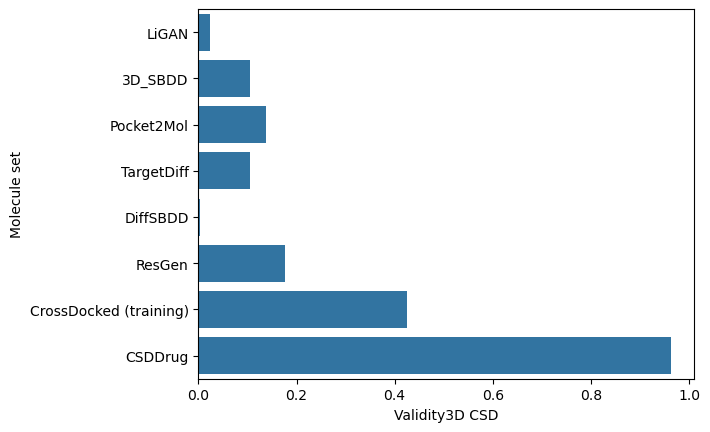

In [72]:
sns.barplot(data=nonmin_df, 
            x='Validity3D CSD',
            y='Molecule set')

<Axes: xlabel='Strain energy', ylabel='Molecule set'>

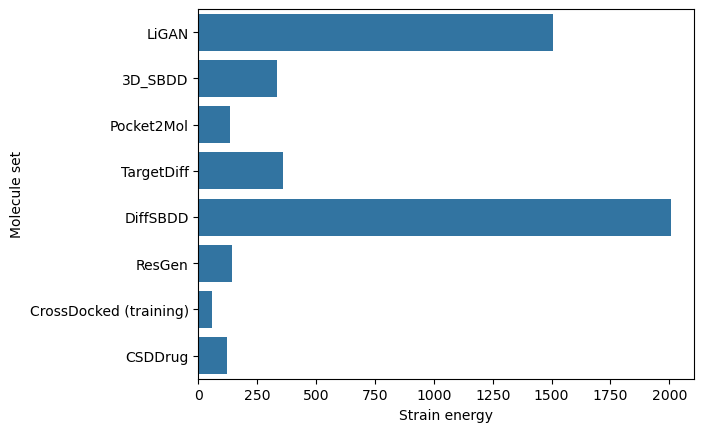

In [73]:
sns.barplot(data=nonmin_df, 
            x='Strain energy',
            y='Molecule set')

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


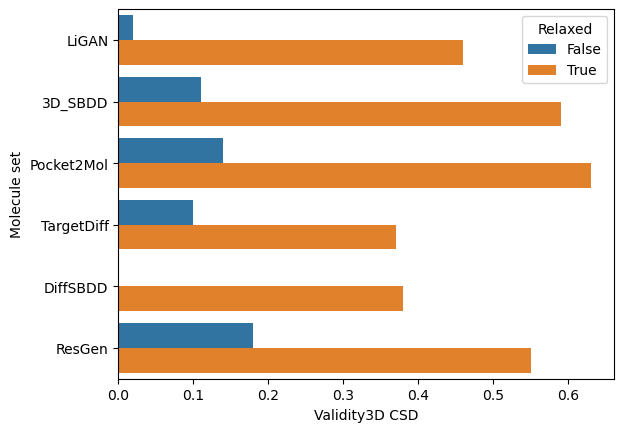

In [15]:
ax = sns.barplot(data=df[df['Molecule set'].isin(model_names)].round(2),
           x='Validity3D CSD',
           y='Molecule set',
           hue='Relaxed',
           order=model_names)
plt.savefig('figures/Validity3D.png', dpi=300, bbox_inches='tight')
# for container in ax.containers:
#     ax.bar_label(container)

In [13]:
df[df['Molecule set'].isin(model_names)][['Model', 'Minimized', 'Validity3D CSD']]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


,Model,Minimized,Validity3D CSD
0,LiGAN,False,0.022854
1,LiGAN,True,0.461475
2,3D_SBDD,False,0.105476
3,3D_SBDD,True,0.593785
4,Pocket2Mol,False,0.138770
5,Pocket2Mol,True,0.633662
6,TargetDiff,False,0.104692
7,TargetDiff,True,0.370893
8,DiffSBDD,False,0.004100
9,DiffSBDD,True,0.382575


In [10]:
min_df = df[df['Relaxed']]

In [11]:
min_df[['Molecule set', 
           'Uniqueness3D', 
           'Diversity3D', 
           'Novelty3D']].round(4).sort_values('Molecule set')

,Molecule set,Uniqueness3D,Diversity3D,Novelty3D
1,LiGAN,0.8077,0.4768,0.3333
3,3D_SBDD,0.4212,0.2485,0.3906
5,Pocket2Mol,0.3764,0.1970,0.1021
7,TargetDiff,0.6827,0.3707,0.2346
9,DiffSBDD,0.5000,0.1142,0.5000
11,ResGen,0.4230,0.2741,0.1590


In [72]:
min_df[['Molecule set', 
           'Validity3D CSD', 
           'Min bond q-value (Validity3D CSD)',
           'Min angle q-value (Validity3D CSD)',
           # 'Min torsion q-value (Validity3D CSD)',
           'Min bond+angle q-value (Validity3D CSD)',
           # 'Min bond+angle+torsion q-value (Validity3D CSD)',
           'Geometric mean bond q-value (Validity3D CSD)',
           'Geometric mean angle q-value (Validity3D CSD)',
           # 'Geometric mean torsion q-value (Validity3D CSD)',
           'Geometric mean bond+angle q-value (Validity3D CSD)',
           # 'Geometric mean bond+angle+torsion q-value (Validity3D CSD)',
          'Strain energy']].round(4).sort_values('Molecule set')

,Molecule set,Validity3D CSD,Min bond q-value (Validity3D CSD),Min angle q-value (Validity3D CSD),Min bond+angle q-value (Validity3D CSD),Geometric mean bond q-value (Validity3D CSD),Geometric mean angle q-value (Validity3D CSD),Geometric mean bond+angle q-value (Validity3D CSD),Strain energy
1,LiGAN,0.4615,0.0540,0.0004,0.0002,0.3761,0.1161,0.1927,30.0444
3,3D_SBDD,0.5938,0.0960,0.0062,0.0055,0.4808,0.2443,0.3362,15.6704
5,Pocket2Mol,0.6337,0.0600,0.0092,0.0064,0.4752,0.3317,0.3799,10.0665
7,TargetDiff,0.3709,0.0367,0.0001,0.0001,0.4151,0.1811,0.2624,28.7276
9,DiffSBDD,0.3826,0.0568,0.0001,0.0000,0.4525,0.1522,0.2523,36.2215
11,ResGen,0.5475,0.0457,0.0042,0.0027,0.4443,0.2789,0.3348,14.3495


In [31]:
nonmin_df[~nonmin_df['Molecule set'].isin(model_names)][['Molecule set', 
           'Validity3D CSD', 
           'Min bond q-value (Validity3D CSD)',
           'Min angle q-value (Validity3D CSD)',
           'Min torsion q-value (Validity3D CSD)',
           'Min bond+angle q-value (Validity3D CSD)',
           'Min bond+angle+torsion q-value (Validity3D CSD)',
           'Geometric mean bond q-value (Validity3D CSD)',
           'Geometric mean angle q-value (Validity3D CSD)',
           'Geometric mean torsion q-value (Validity3D CSD)',
           'Geometric mean bond+angle q-value (Validity3D CSD)',
           'Geometric mean bond+angle+torsion q-value (Validity3D CSD)',
          'Strain energy']].round(4).sort_values('Molecule set')

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


,Molecule set,Validity3D CSD,Min bond q-value (Validity3D CSD),Min angle q-value (Validity3D CSD),Min torsion q-value (Validity3D CSD),Min bond+angle q-value (Validity3D CSD),Min bond+angle+torsion q-value (Validity3D CSD),Geometric mean bond q-value (Validity3D CSD),Geometric mean angle q-value (Validity3D CSD),Geometric mean torsion q-value (Validity3D CSD),Geometric mean bond+angle q-value (Validity3D CSD),Geometric mean bond+angle+torsion q-value (Validity3D CSD),Strain energy
12,CrossDocked (training),0.4261,0.0125,0.0023,0.0003,0.0002,0.0000,0.3494,0.3257,0.2892,0.3078,0.2667,56.1069
13,CSDDrug,0.9627,0.1766,0.1365,0.1196,0.1040,0.0649,0.6262,0.5916,0.5665,0.6016,0.5777,120.0858


In [74]:
min_rows = []
for filepath in filepaths:
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    model_name = '_'.join(filepath.split('_')[1:]).split('.')[0]
    minimized = False
    if 'minimized' in model_name:
        minimized = True
        model_name = '_'.join(model_name.split('_')[:-1])
    for name, values in results.items():
        if 'Min' in name:
            for value in values:
                row = {'Model' : model_name,
                      'Minimized': minimized,
                      'Name': name,
                      'Value': value}
                min_rows.append(row)

In [75]:
min_df = pd.DataFrame(min_rows)

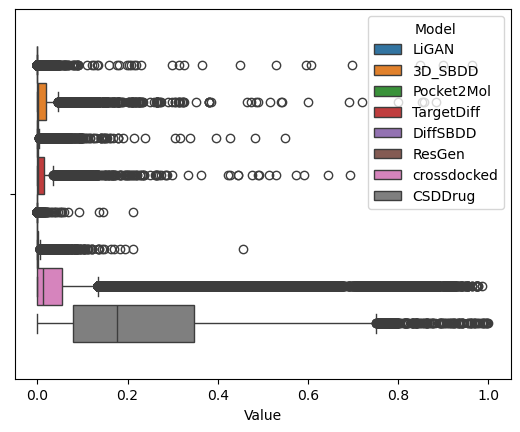

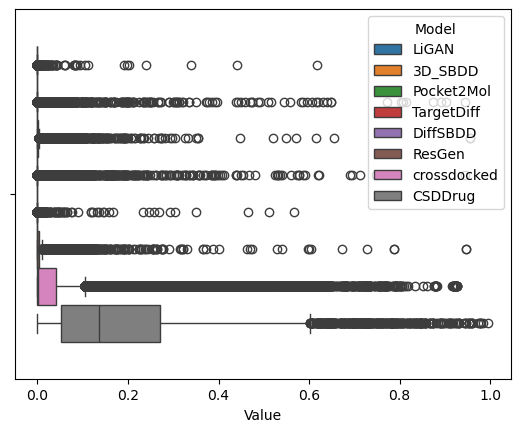

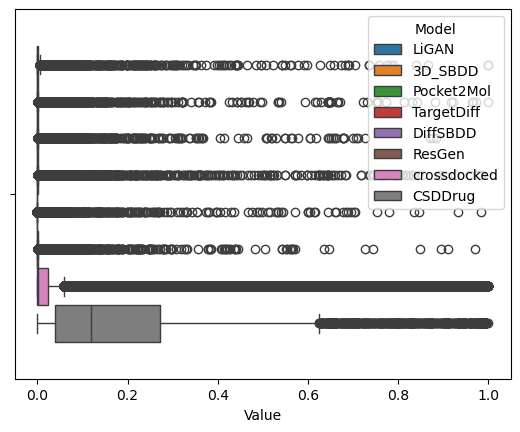

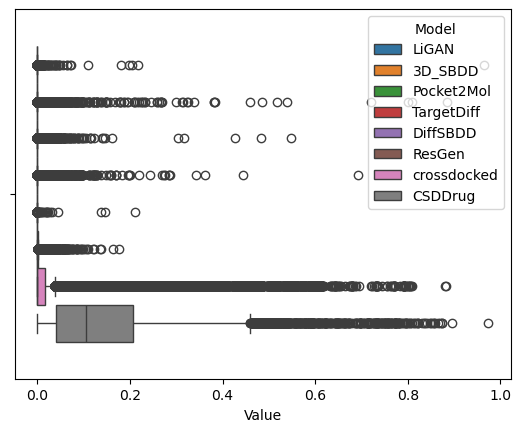

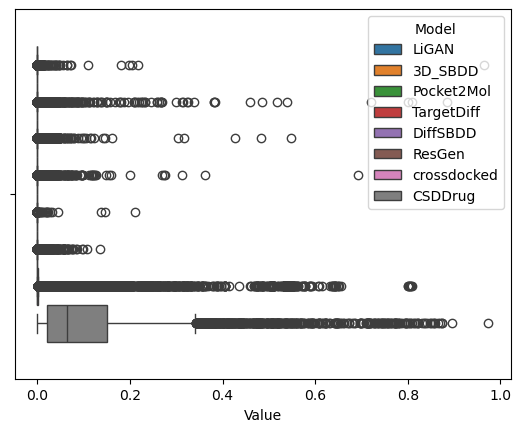

In [83]:
for name in min_df['Name'].unique():
    sns.boxplot(data=min_df[(~min_df['Minimized']) & (min_df['Name'] == name)],
           x='Value',
           hue='Model')
    plt.show()

In [84]:
geo_rows = []
for filepath in filepaths:
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    model_name = '_'.join(filepath.split('_')[1:]).split('.')[0]
    minimized = False
    if 'minimized' in model_name:
        minimized = True
        model_name = '_'.join(model_name.split('_')[:-1])
    for name, values in results.items():
        if 'Geometric' in name:
            for value in values:
                row = {'Model' : model_name,
                      'Minimized': minimized,
                      'Name': name,
                      'Value': value}
                geo_rows.append(row)

In [88]:
geo_df = pd.DataFrame(geo_rows)

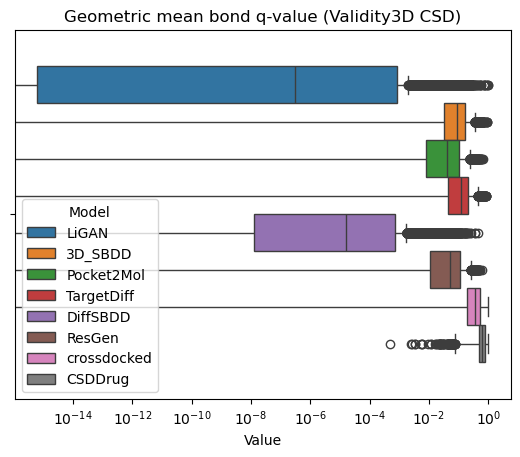

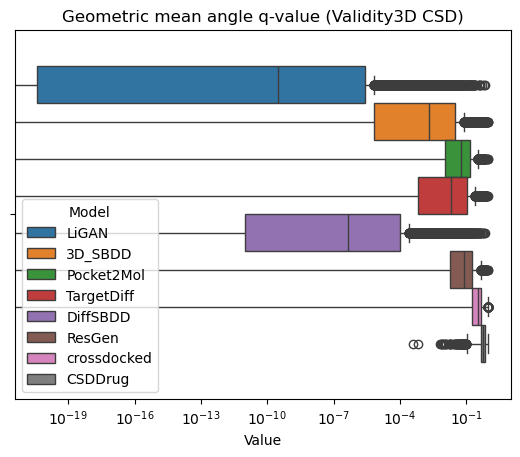

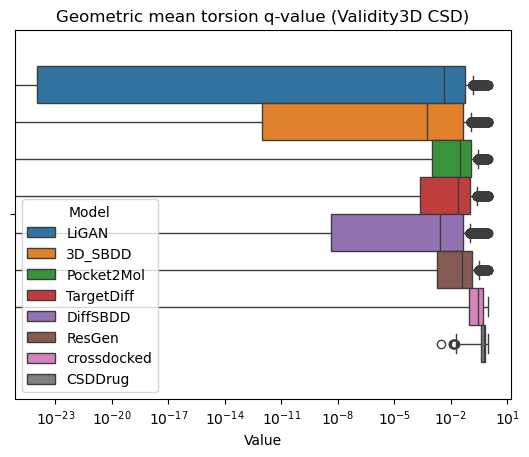

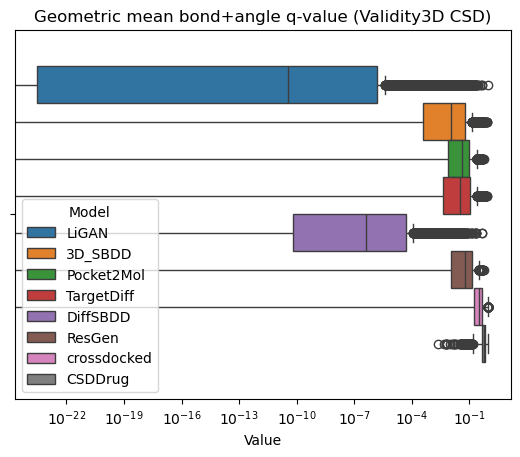

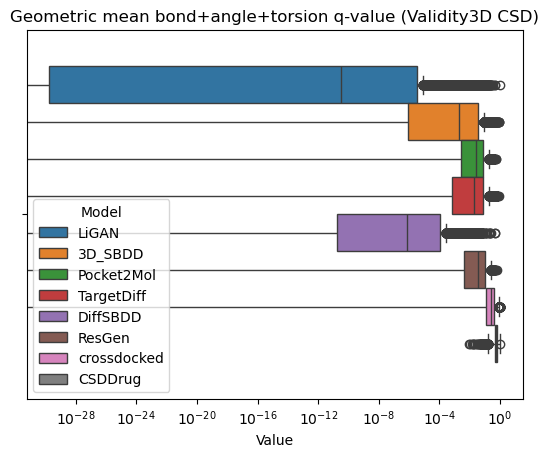

In [95]:
for name in geo_df['Name'].unique():
    f = sns.boxplot(data=geo_df[(~geo_df['Minimized']) & (geo_df['Name'] == name)],
           x='Value',
           hue='Model')
    f.set_xscale("log")
    plt.title(name)
    plt.show()